In [117]:
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

In [123]:
from google.colab import drive
import pandas as pd

# Google Drive'ı bağla
#drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)


# Veri setini yükle
#file_path = '/content/drive/My Drive/sentiment analysis/final_df.csv'
file_path = '/content/drive/My Drive/BitirmeMuammer/imdb/IMDB_Dataset.csv'
file_path2 = '/content/drive/My Drive/BitirmeMuammer/USAir/final_df_balanced.csv'
df = pd.read_csv(file_path2, encoding='latin1', header=None)

# Sütun isimlerini belirle
df.columns = ['review', 'sentiment',]

# İlk sütunu kontrol edelim
print("Sütun isimleri:", df.columns)

Mounted at /content/drive
Sütun isimleri: Index(['review', 'sentiment'], dtype='object')


In [124]:
df = df.drop(df.index[0])

In [134]:
# Önce veri tipini dönüştür
df["sentiment"] = df["sentiment"].astype(int)

# Ardından eşleştirme işlemini yap
label_map = {-1: "negative", 0: "neutral", 1: "positive"}
df["sentiment"] = df["sentiment"].map(label_map)


In [125]:
df.head()

,review,sentiment
1,"At Wipro, growth remains a mirage",-1
2,Why Chinese stocks leave US investors vulnerable,-1
3,US stocks finish mixed amid more tech selling,-1
4,Opec reduces estimate on oil demand growth,-1
5,Immediate support for rupee is placed at 55.10...,-1


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [8]:
"""df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()"""

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14741 entries, 1 to 14741
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     14741 non-null  object
 1   sentiment  14741 non-null  object
dtypes: object(2)
memory usage: 230.5+ KB


>Checking for null values:

In [136]:
df.isnull().sum()

,0
review,0
sentiment,0


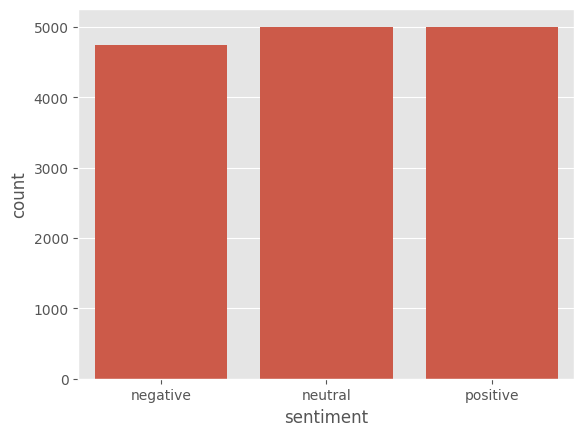

In [137]:
import seaborn as sns
plt.style.use("ggplot")
sns.countplot(data = df, x = df["sentiment"])
plt.show()

In [158]:
df["sentiment"].value_counts()

,count
sentiment,
neutral,5000
positive,5000
negative,4741


In [128]:
df = df[df['sentiment'] .values!= 0]

- So, there is no class imbalance both class has an equal number of data.

In [138]:
import re
import nltk
import spacy
from nltk.corpus import stopwords
import en_core_web_sm
# Gerekli kaynakları indir
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)


class CustomPreprocess():

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()

        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)

        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)

        return sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [139]:
custom = CustomPreprocess()
custom.preprocess_text("I thought this was a wonderful way to spend time on a too hot summer weekend")

'thought wonderful way spend time hot summer weekend'

In [140]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [141]:
y = df['sentiment']
y[250:]

,sentiment
251,negative
252,negative
253,negative
254,negative
255,negative
...,...
14737,positive
14738,positive
14739,positive
14740,positive


In [142]:
y.shape

(14741,)

In [159]:
y = df['sentiment']
sentiment_map = {'negative' : 0, 'neutral':1,'positive': 2}
y = np.array(y.map(sentiment_map))
y[:1500]

array([0, 0, 0, ..., 0, 0, 0])

In [160]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [161]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [162]:
vocab_length = len(tokenizer.word_index)+1
vocab_length

13667

In [163]:
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [164]:
x_train

array([[ 2082,  2083,     2, ...,     0,     0,     0],
       [ 2795,   254,   211, ...,     0,     0,     0],
       [ 1559,    11,   954, ...,     0,     0,     0],
       ...,
       [  700,   873,   625, ...,     0,     0,     0],
       [   60,  2170,    24, ...,     0,     0,     0],
       [  162, 13666,   477, ...,     0,     0,     0]], dtype=int32)

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
# GloVe dosya yolu (Google Drive'daki konum)
glove_path = "/content/drive/My Drive/BitirmeMuammer/imdb/glove.6B.100d.txt"

# Embedding sözlüğünü oluşturma
embeddings_dictionary = dict()
with open(glove_path, encoding='utf8') as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions


In [166]:
print(list(tokenizer.word_index.items())[:15])

[('eur', 1), ('net', 2), ('mn', 3), ('profit', 4), ('rs', 5), ('company', 6), ('stocks', 7), ('year', 8), ('sales', 9), ('million', 10), ('shares', 11), ('crore', 12), ('finnish', 13), ('said', 14), ('co', 15)]


In [167]:
embeddings_dictionary.get('film')

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [168]:
embedding_matrix = np.zeros((vocab_length, 100)) #100
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [169]:
embedding_matrix.shape

(13667, 100)

> Model Building:
>> Convenitonal Neural Network:

In [170]:
from keras.layers import Conv1D
cnn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
cnn.add(embedding_layer)
cnn.add(Conv1D(128,5,activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Conv1D(256,5,activation = 'relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [157]:
y_train

array([ 1.,  1.,  0., ..., nan,  0., nan])

In [173]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cnn.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     1,366,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,700 (5.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,366,700 (5.21 MB)

In [172]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     1,366,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,700 (5.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,366,700 (5.21 MB)

In [174]:
x_train

array([[ 2082,  2083,     2, ...,     0,     0,     0],
       [ 2795,   254,   211, ...,     0,     0,     0],
       [ 1559,    11,   954, ...,     0,     0,     0],
       ...,
       [  700,   873,   625, ...,     0,     0,     0],
       [   60,  2170,    24, ...,     0,     0,     0],
       [  162, 13666,   477, ...,     0,     0,     0]], dtype=int32)

In [183]:
from keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()

# Embedding katmanı
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn.add(embedding_layer)

# 1. Conv1D katmanı
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(Dropout(0.2))

# 2. Conv1D katmanı
cnn.add(Conv1D(256, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())

# Son katman: 3 sınıf için softmax aktivasyonu
cnn.add(Dense(3, activation='softmax'))

# Modeli derle
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model özeti
cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     1,366,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,700 (5.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,366,700 (5.21 MB)

In [185]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [194]:
print("y_train shape: ", y_train.shape)  # (num_samples, 3) olmalı
print("y_test shape: ", y_test.shape)    # (num_samples, 3) olmalı


y_train shape:  (11792, 3, 3)
y_test shape:  (2949, 3)


In [196]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam

# Assuming 'embedding_matrix' and 'vocab_length' are defined
cnn = Sequential()
cnn.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(256, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(3, activation='sigmoid'))  # Output layer for multi-label classification

cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

# Train the model
history_cnn = cnn.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     1,366,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,700 (5.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,366,700 (5.21 MB)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 3, 3), output.shape=(None, 3)

In [195]:
history_cnn = cnn.fit(x_train, y_train, batch_size=128, epochs=10,
                      verbose=1, validation_data=(x_test, y_test))



Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 3, 3), output.shape=(None, 3)

In [192]:
history_cnn = cnn.fit(x_train, y_train, batch_size=128, epochs=10,
                      verbose=1, validation_data=(x_test, y_test))


Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 3, 3), output.shape=(None, 3)

In [190]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 3, 3), output.shape=(None, 3)

In [177]:
y[5000]

np.int64(1)

In [181]:
import numpy as np
print(np.unique(y_train))         # 0, 1, 2 mi?
#print(y_train_ohe[:5])            # one-hot mı? (örn. [0. 1. 0.])


[0 1 2]


In [182]:
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train, num_classes=3).astype("float32")
print(y_train_ohe[:5])


[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [178]:
history_cnn = cnn.fit(x_train,y_train, batch_size=64, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - accuracy: 0.3501 - loss: 0.0000e+00 - val_accuracy: 0.3518 - val_loss: 0.0000e+00
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.3469 - loss: 0.0000e+00 - val_accuracy: 0.3518 - val_loss: 0.0000e+00
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.3577 - loss: 0.0000e+00 - val_accuracy: 0.3518 - val_loss: 0.0000e+00
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.3522 - loss: 0.0000e+00 - val_accuracy: 0.3518 - val_loss: 0.0000e+00
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.3473 - loss: 0.0000e+00 - val_accuracy: 0.3518 - val_loss: 0.0000e+00
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 33s 224ms/step - accuracy: 0.3554 - loss: 0.0000e+00 - val_accuracy: 0.3518 - val_loss: 0.0000e+00
Epoch 7/10
138/148 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.3567 - loss: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8458 - loss: 0.4118
Test Accuracy: 0.8472999930381775
Test Loss: 0.4079468250274658


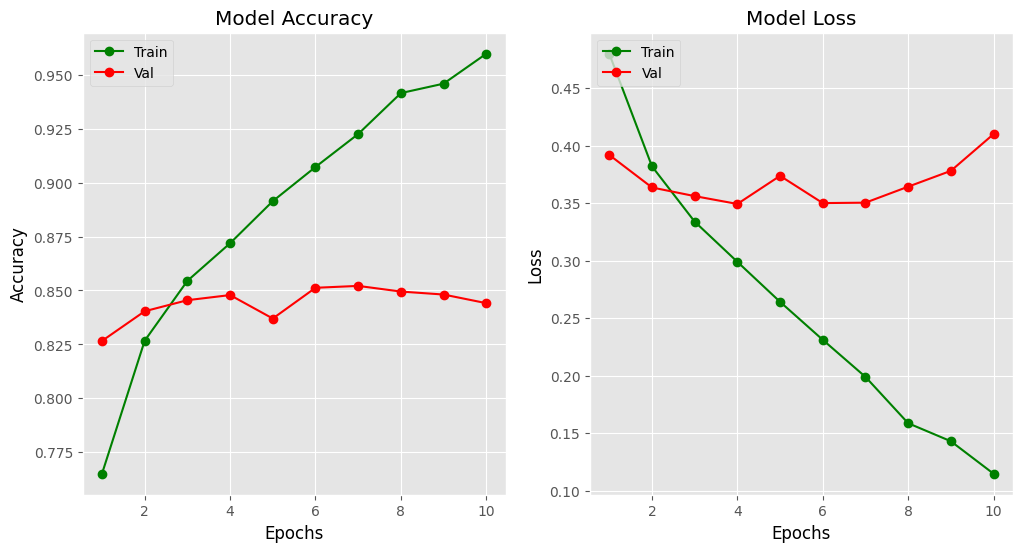

In [ ]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_cnn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_cnn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> LSTM

In [ ]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm.add(embedding_layer)
lstm.add(LSTM(256)) #return_sequences=True
# lstm.add(LSTM(128, return_sequences=True))

# lstm.add(Dropout(0.2))
# lstm.add(LSTM(64))


# cnn.add(Conv1D(512,5,activation = 'relu'))
# cnn.add(GlobalMaxPooling1D())

lstm.add(Dense(1,activation = 'sigmoid'))

In [ ]:
lstm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [ ]:
history_lstm = lstm.fit(x_train,y_train, batch_size=128, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 218s 864ms/step - accuracy: 0.6925 - loss: 0.5800 - val_accuracy: 0.7806 - val_loss: 0.5084
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 256s 842ms/step - accuracy: 0.7941 - loss: 0.4558 - val_accuracy: 0.8242 - val_loss: 0.3992
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 258s 827ms/step - accuracy: 0.8311 - loss: 0.3920 - val_accuracy: 0.8399 - val_loss: 0.4027
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 263s 832ms/step - accuracy: 0.8431 - loss: 0.3684 - val_accuracy: 0.8531 - val_loss: 0.3347
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 267s 852ms/step - accuracy: 0.8593 - loss: 0.3319 - val_accuracy: 0.8496 - val_loss: 0.3653
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 217s 870ms/step - accuracy: 0.8743 - loss: 0.3076 - val_accuracy: 0.8627 - val_loss: 0.3279
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 258s 854ms/step - accuracy: 0.8818 - loss: 0.2860 - val_accuracy: 0.8662 - val_loss: 0.3198
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 258s 836ms/step - accuracy: 0.8906 -

In [ ]:
lstm_result = lstm.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.8623 - loss: 0.3538
Test Accuracy: 0.8628000020980835
Test Loss: 0.3478984236717224


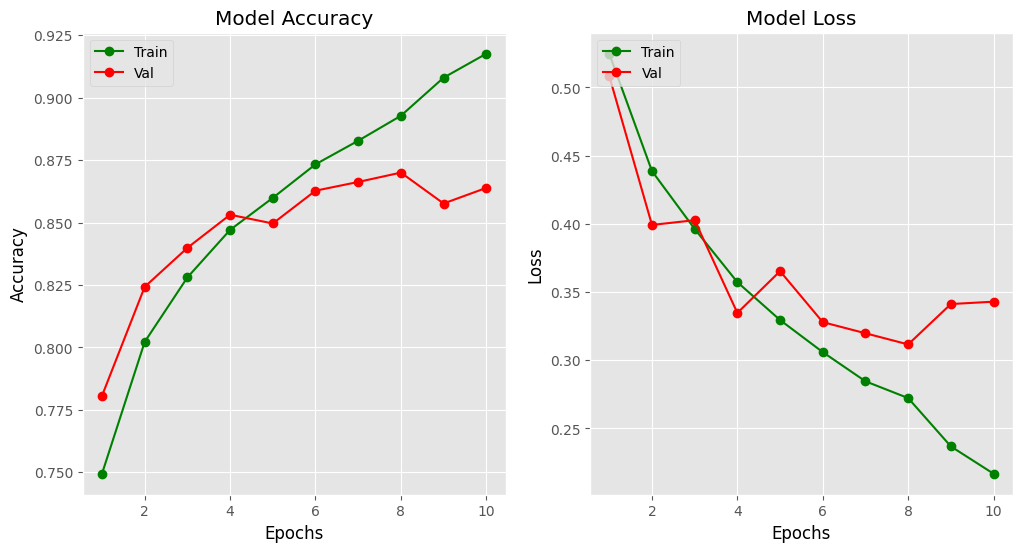

In [ ]:
plt.figure(figsize=(12,6))
epochs = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epochs,history_lstm.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_lstm.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [ ]:
lstm.save("sentiment_classifier2.h5")

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model parametreleri
embedding_dim = 100
lstm_units = 512
dropout_rate = 0.5
activation_fn = 'tanh'
learning_rate = 0.002
batch_size = 256
epochs = 10

# Bi-LSTM modeli
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(units=lstm_units, activation=activation_fn, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# Derleme
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# Early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Eğitim
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 1404s 11s/step - accuracy: 0.6525 - loss: 0.6431 - val_accuracy: 0.8468 - val_loss: 0.5846
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1360s 11s/step - accuracy: 0.9333 - loss: 0.1759 - val_accuracy: 0.8591 - val_loss: 0.4502
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1394s 11s/step - accuracy: 0.9817 - loss: 0.0555 - val_accuracy: 0.8646 - val_loss: 0.3386
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1378s 11s/step - accuracy: 0.9924 - loss: 0.0233 - val_accuracy: 0.8515 - val_loss: 0.4123
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1415s 11s/step - accuracy: 0.9953 - loss: 0.0155 - val_accuracy: 0.8600 - val_loss: 0.7708
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1385s 11s/step - accuracy: 0.9950 - loss: 0.0167 - val_accuracy: 0.8478 - val_loss: 0.7298


In [ ]:
# Model özeti
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (256, 100, 100)        │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (256, 1024)            │     2,510,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (256, 1024)            │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (256, 1024)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (256, 1)               │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,262,013 (134.51 MB)

 Trainable params: 11,753,321 (44.84 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 23,506,644 (89.67 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 160s 510ms/step


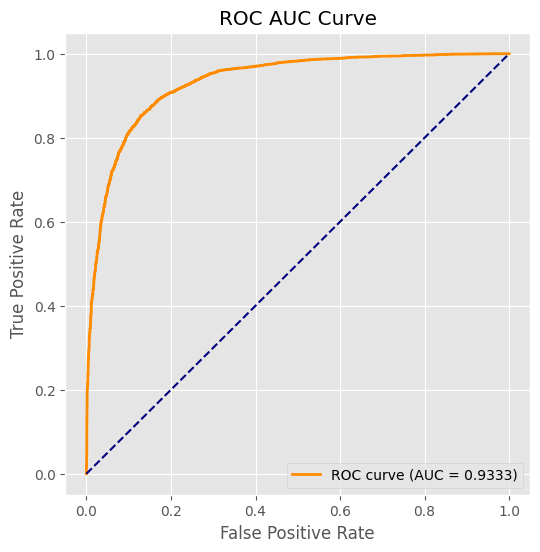

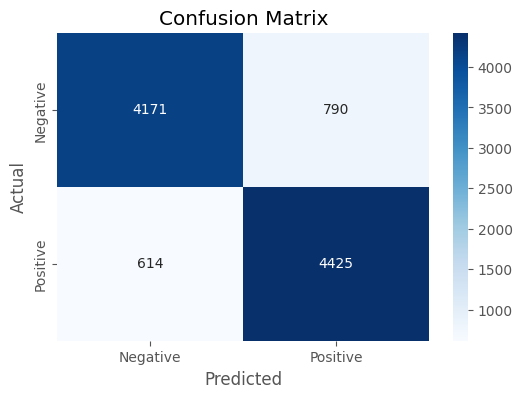

📌 Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.86      4961
    Positive       0.85      0.88      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



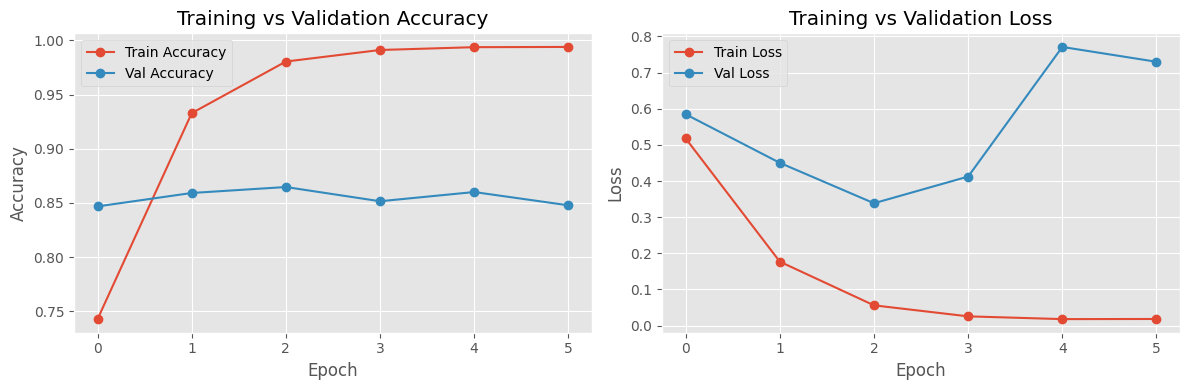

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Tahmin ve sınıflandırma ---
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

# --- 2. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 4. Classification Report ---
print("📌 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# --- 5. Accuracy ve Loss Grafikleri ---
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
